<a href="https://colab.research.google.com/github/danshal/DL_project/blob/develop/wav2vec_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Uploading Files To Google Cloud Storage (speaker_verification_bucket)

In [2]:
from google.colab import auth
auth.authenticate_user()
project_id = 'cogent-point-302020'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://speaker_verification_bucket/


###After running this cell, all files will be in the bucket. From bucket we can upload them to a folder on the remote machine!

In [3]:
bucket_name = 'speaker_verification_bucket'

!gsutil -m cp -r /content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/* gs://{bucket_name}/

Streaming output truncated to the last 5000 lines.
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-165.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-166.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-167.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-168.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-169.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/84/84-170.pt [Content-Type=application/octet-stream]...
Copying file:///content/drive/MyDrive/DeepProject/wav2vec/SV_

##Install fairseq and more packages

In [ ]:
!pip install soundfile git+git://github.com/pytorch/fairseq.git@b8ea8a9b72c82192da07e3377adf4ebbde16716d
!pip install fairseq
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#!mkdir fairseq_code
#%cd /content/drive/MyDrive/DeepProject/wav2vec/fairseq_code/
#!git clone https://github.com/pytorch/fairseq.git

  Cloning git://github.com/pytorch/fairseq.git (to revision b8ea8a9b72c82192da07e3377adf4ebbde16716d) to /tmp/pip-req-build-k8vi05ss
  Running command git clone -q git://github.com/pytorch/fairseq.git /tmp/pip-req-build-k8vi05ss
  Running command git checkout -q b8ea8a9b72c82192da07e3377adf4ebbde16716d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 133kB 10.8MB/s 
     |████████████████████████████████| 645kB 11.7MB/s 
     |████████████████████████████████| 112kB 15.2MB/s 
  Created wheel for fairseq: filename=fairseq-1.0.0a0+b8ea8a9-cp36-cp36m-linux_x86_64.whl size=2713501 sha256=5d917d8750af085db734dc3b68fd2ca2abc3bc53a7e92407d4f00f2a2904b437
  Stored in directory: /tmp/pip-ephem-wheel-cache-hwn4rcmh/wheels/39/

##Imports

In [ ]:
#General imports
import argparse
import glob
import os
import os.path as osp
import pprint
import soundfile as sf
from typing import Tuple
#facebook team framework
import fairseq
#pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
    download_url,
    extract_archive,
    walk_files,
)
#matplotlib
import matplotlib.pyplot as plt
#numpy
import numpy as np
#pandas
import pandas as pd
try:
    import tqdm
except:
    print("Install tqdm to use --log-format=tqdm")

In [ ]:
import torch
print(torch.__version__)
!nvcc --version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

##Get Trained Model & Try Sanity Code

In [4]:
cp_path = '/content/drive/My Drive/DeepProject/wav2vec/wav2vec_large.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

wav_input_16khz = torch.randn(1,10000)
z = model.feature_extractor(wav_input_16khz)
c = model.feature_aggregator(z)
print(f'input shape = {wav_input_16khz.shape} ; z shape = {z.shape} ; z shape = {c.shape}')

NameError: ignored

In [7]:
#@title Hyperparametes
batch_size = 32 #@param {type:"number"}
epochs = 10 #@param {type:"number"}
learning_rate = 0.001 #@param {type:"number"}
optimizer_type = "Adam" #@param ["Adam", "AdamW", "SGD"]
waveform_length_in_seconds = 3 #@param {type:"slider", min:0, max:15, step:1}
sample_rate = 16000 #@param {type:"number"}

###Download Dataset
###Information about LibriSpeech dataset:
1. Total of 982 hours of 16KHz read English speech
2. 2484 speakers in this corpus.
3. Suppose to be reasonably balances in terms of gender and per-speaker duration
4. Allowed urls for LIBRISPEECH - "dev-clean", "dev-other", "test-clean", "test-other", "train-clean-100", "train-clean-360" and "train-other-500". (default: "train-clean-100")

In [ ]:
# rootDir = '/content/drive/MyDrive/DeepProject/wav2vec/'
# # Download training data
# train_data = torchaudio.datasets.LIBRISPEECH(f'{rootDir}/dataset/', download=True)
# # Download test data
# test_data = torchaudio.datasets.LIBRISPEECH(f'{rootDir}/dataset/', url='test-clean', download=True)

##Helper Functions

In [8]:
def read_audio(fname):
    ''' Load an audio file and return PCM along with the sample rate '''

    wav, sr = sf.read(fname)
    assert sr == 16e3

    return wav, 16e3


def audio2tensor(fname):
  ''' This function will convert audio samples to tensor '''
  input, _ = read_audio(fname)
  input_tensor = torch.from_numpy(input).float()
  return input_tensor.reshape(1, input_tensor.size(0))


def get_audio_repr(fname):
  ''' This function will get audio as input and will output its representation
      as wav2vec model outputs '''
  input_tensor = audio2tensor(fname)
  z = model.feature_extractor(input_tensor)
  c = model.feature_aggregator(z)
  return c


def get_tensor_repr(input_tensor):
  ''' This function will get a tensor and return its representation as wav2vec
     model outputs '''
  with torch.no_grad():
    z = model.feature_extractor(input_tensor)
    c = model.feature_aggregator(z)
    return c


def get_sv_example_generator(data):
  ''' This function gets data that loaded as LIBRISPEECH dataset and yields its
     wav2vec tensor representation with the speaker id ''' 
  train_data_iter = iter(data)
  for i in train_data_iter:
    yield [get_tensor_repr(i[0]), i[3]]


def get_utterances_number(train_data):
  ''' This function gets train_data(dataset object) and returns number of
     utterances per one audio file '''
  example = next(iter(train_data))
  width = example[0].shape[2]
  return width


def get_speakers_num(dataset_path):
  ''' This function will get the dataset path and will return number of
     subdirectoris in this path that is equal ti the number of speakers in this
     dataset '''
  num_speakers = len(list(os.walk(dataset_path)))
  return num_speakers

##Make My Own Dataset Class

In [51]:
rootDir = '/content/drive/MyDrive/DeepProject/wav2vec/'
URL = "train-clean-100"
FOLDER_IN_ARCHIVE_THREE_SEC_REPR = "SV_Librispeech_Latent_Dataset_new"
FOLDER_IN_ARCHIVE_THREE_SEC_AUDIO = "SV_Librispeech_Dataset"
FOLDER_IN_ARCHIVE_ORIGINAL_LIBRI = "LibriSpeech"
_CHECKSUMS = {
    "http://www.openslr.org/resources/12/dev-clean.tar.gz":
    "76f87d090650617fca0cac8f88b9416e0ebf80350acb97b343a85fa903728ab3",
    "http://www.openslr.org/resources/12/dev-other.tar.gz":
    "12661c48e8c3fe1de2c1caa4c3e135193bfb1811584f11f569dd12645aa84365",
    "http://www.openslr.org/resources/12/test-clean.tar.gz":
    "39fde525e59672dc6d1551919b1478f724438a95aa55f874b576be21967e6c23",
    "http://www.openslr.org/resources/12/test-other.tar.gz":
    "d09c181bba5cf717b3dee7d4d592af11a3ee3a09e08ae025c5506f6ebe961c29",
    "http://www.openslr.org/resources/12/train-clean-100.tar.gz":
    "d4ddd1d5a6ab303066f14971d768ee43278a5f2a0aa43dc716b0e64ecbbbf6e2",
    "http://www.openslr.org/resources/12/train-clean-360.tar.gz":
    "146a56496217e96c14334a160df97fffedd6e0a04e66b9c5af0d40be3c792ecf",
    "http://www.openslr.org/resources/12/train-other-500.tar.gz":
    "ddb22f27f96ec163645d53215559df6aa36515f26e01dd70798188350adcb6d2"
}


def load_sv_librispeech_item(fileid: str, path: str, ext: str = '.pt') -> Tuple[Tensor, int]:
    '''This function return example as wav2vec representation or librispeech audio
       representation from a given path'''
    speaker_id, utterance_id = fileid.split("-")
    file_to_load = fileid + ext
    file_path = os.path.join(path, speaker_id, file_to_load)
    if ext == '.flac':
      input, _ = torchaudio.load(file_path) # Load audio - dont care about sample rate
    else:
      input = torch.load(file_path)
    return (input, int(speaker_id))


# create my own collate function to avoid stacking same size examples in a batch
def my_collate(batch):
    data = [item[0] for item in batch]  #get 512 X ? tensor in item[0]
    data = tuple(data)
    data = torch.cat(data)
    data = data.detach().clone()
    target = [item[1] for item in batch]        
    target = torch.LongTensor(target)
    return [data, target]


class SV_LIBRISPEECH(Dataset):
    """Create a Dataset for SV_LibriSpeech.

    Args:
        root (str): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from,
            or the type of the dataset to dowload.
            Allowed type values are ``"dev-clean"``, ``"dev-other"``, ``"test-clean"``,
            ``"test-other"``, ``"train-clean-100"``, ``"train-clean-360"`` and
            ``"train-other-500"``. (default: ``"train-clean-100"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"LibriSpeech"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    _ext_audio = ".flac"
    _ext_repr = ".pt"

    def __init__(self, root: str, url: str = URL,
                 folder_in_archive: str = FOLDER_IN_ARCHIVE_THREE_SEC_REPR,
                 download: bool = False, is_SV: bool = True, wav2vec_fine_tuning: bool = False) -> None:

        if url in [
            "dev-clean",
            "dev-other",
            "test-clean",
            "test-other",
            "train-clean-100",
            "train-clean-360",
            "train-other-500",
        ]:
            ext_archive = ".tar.gz"
            base_url = "http://www.openslr.org/resources/12/"

            url = os.path.join(base_url, url + ext_archive)

        basename = os.path.basename(url)
        archive = os.path.join(root, basename)

        basename = basename.split(".")[0]
        if is_SV == False:
          folder_in_archive = os.path.join(folder_in_archive, basename)

        self._path = os.path.join(root, folder_in_archive)

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    checksum = _CHECKSUMS.get(url, None)
                    download_url(url, root, hash_value=checksum)
                extract_archive(archive)
        
        self._ext = self._ext_audio
        if folder_in_archive == FOLDER_IN_ARCHIVE_THREE_SEC_REPR:
          self._ext = self._ext_repr
        walker = walk_files(self._path, suffix=self._ext, prefix=False, remove_suffix=True)
        self._walker = list(walker)
        self.ft = wav2vec_fine_tuning
  

    def __getitem__(self, n: int) -> Tuple[Tensor, int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            tuple: ``(waveform, speaker_id)``
        """
        fileid = self._walker[n]  #get file name without .flac suffix        
        #librispeech_item, speaker_id = load_sv_librispeech_item(fileid, self._path, self._ext_audio)
        return load_sv_librispeech_item(fileid, self._path, self._ext)

    def __len__(self) -> int:
      return len(self._walker)


my_train_data = SV_LIBRISPEECH('/content/drive/MyDrive/DeepProject/wav2vec/',
                               folder_in_archive = FOLDER_IN_ARCHIVE_THREE_SEC_REPR)
print(f'Number of training examples(utterances): {len(my_train_data)}')
#my_train_loader = torch.utils.data.DataLoader(my_train_data, batch_size=batch_size, shuffle=True, collate_fn=my_collate)
my_train_loader = torch.utils.data.DataLoader(my_train_data, batch_size=batch_size, shuffle=True)

#WHAT ABOUT LOADING TEST DATASET???????????? -> For now i get the audio examples but we have to convert them to the same repr as the training!
my_test_data = SV_LIBRISPEECH('/content/drive/MyDrive/DeepProject/wav2vec/dataset',
                              url = "test-clean",
                              folder_in_archive = FOLDER_IN_ARCHIVE_ORIGINAL_LIBRI,
                              is_SV = False)
print(f'Number of test examples(utterances): {len(my_test_data)}')
#my_test_loader = torch.utils.data.DataLoader(my_test_data, batch_size=batch_size, shuffle=True, collate_fn=my_collate)
my_test_loader = torch.utils.data.DataLoader(my_test_data, batch_size=batch_size, shuffle=True)

Number of training examples(utterances): 69331
Number of test examples(utterances): 2620


# Building SV Datasets Function

In [ ]:
def create_cut_audio_dataset(train_data, waveform_length_in_seconds):
  ''' This function gets SV_LIBRISPEECH object and create dataset(not the object)
      that contains directories per speaker with its audio cuts by
      waveform_length_in_seconds '''
  waveform_length_in_samples = sample_rate * waveform_length_in_seconds
  current_speaker_id, _, _ = train_data._walker[0].split("-")
  speaker_utterace_counter = 0
  file_path = f'{rootDir}SV_Librispeech_Dataset'
  try:  
    os.mkdir(f'{file_path}/{current_speaker_id}')
  except OSError:
    print(f'GOT ERROR while trying to create directory for {current_speaker_id} speaker')
    pass
  for i in train_data._walker:
    # c = c + 1
    # if c > 200:
    #   break
    p = train_data._path[:42] + train_data._path[43:]
    speaker_id, chapter_id, utterance_id = i.split("-")
    if speaker_id!=current_speaker_id:
      speaker_utterace_counter = 0
      current_speaker_id = speaker_id
      os.mkdir(f'{file_path}/{current_speaker_id}')
    fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    file_audio = fileid_audio + train_data._ext_audio
    file_audio = os.path.join(train_data._path, speaker_id, chapter_id, file_audio)
    waveform, _ = torchaudio.load(file_audio) # Load audio - dont care about sample rate
    waveform_length = waveform.shape[1]
    if waveform_length<waveform_length_in_samples:
      continue
    chunks = [waveform[0,x:x+waveform_length_in_samples] for x in range(0, waveform_length, waveform_length_in_samples)]
    num_of_chunks = waveform_length//waveform_length_in_samples
    for chunk_ind in range(0,num_of_chunks-1):
        torchaudio.backend.sox_backend.save(f'{file_path}/{current_speaker_id}/{current_speaker_id}-{speaker_utterace_counter}.flac',chunks[chunk_ind],16000)
        speaker_utterace_counter+=1
    print(waveform_length)


def create_repr_dataset(train_data, waveform_length_in_seconds):
  ''' This function gets SV_LIBRISPEECH object and create dataset(not the object)
      that contains directories per speaker with its audio representations by
      wav2vec model '''
  current_speaker_id, _ = train_data._walker[0].split("-")
  speaker_utterace_counter = 0
  speaker_counter = 0
  file_path = f'{rootDir}SV_Librispeech_Latent_Dataset_new'
  try:  
    os.mkdir(f'{file_path}/{speaker_counter}')
  except OSError:
    print('ERROR delete current dataset folder')
    pass

  for i in train_data._walker:
    # c = c + 1
    # if c > 200:
    #   break
    p = train_data._path[:42] + train_data._path[43:]
    speaker_id, utterance_id = i.split("-")
    if speaker_id != current_speaker_id:
      speaker_utterace_counter = 0
      speaker_counter += 1
      current_speaker_id = speaker_id
      if speaker_counter >= 195:
        os.mkdir(f'{file_path}/{speaker_counter}')
    if speaker_counter >= 194:
      fileid_audio = speaker_id + "-"  + utterance_id
      file_audio = fileid_audio + train_data._ext_audio
      file_audio = os.path.join(train_data._path, speaker_id, file_audio)
      waveform, _ = torchaudio.load(file_audio) # Load audio - dont care about sample rate
      waveform_tensor = get_tensor_repr(waveform)
      torch.save(waveform_tensor, f'{file_path}/{speaker_counter}/{speaker_counter}-{speaker_utterace_counter}.pt')
      speaker_utterace_counter+=1
      print(speaker_counter)

##Get Number Of Utterances Vectors -> Input Width

In [10]:
width = get_utterances_number(my_train_data)
print(f'Input width = {width}')

Input width = 298


##Get Number Of Speakers (subdirectories)

In [53]:
num_speakers = get_speakers_num('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Latent_Dataset_new/')
print(f'Speakers number = {num_speakers}')
firstly_num_speakers = get_speakers_num('/content/drive/MyDrive/DeepProject/wav2vec/dataset/LibriSpeech/train-clean-100')
print(f'Speakers number = {firstly_num_speakers}')

Speakers number = 223
Speakers number = 837


##Create dictionary that maps between output neuron index to speaker id *(We can write a simple script that will rename each directory with rising index)*

In [ ]:
my_train_data_for_map = SV_LIBRISPEECH('/content/drive/MyDrive/DeepProject/wav2vec/',
                               folder_in_archive = FOLDER_IN_ARCHIVE_THREE_SEC_AUDIO)
print(f'Number of examples(utterances): {len(my_train_data_for_map)}')
my_train_loader = torch.utils.data.DataLoader(my_train_data_for_map, batch_size=batch_size, shuffle=True, collate_fn=my_collate)
#for 251 speakers its going to take about 3 hours on avarage!!!!!
import time
import json
labels_mapping = {}
it = iter(my_train_data_for_map)
curr_id = next(it)[1]
key_count = 0
labels_mapping[key_count] = curr_id
time0 = time.time()
for i in it:
  if i[1] != curr_id:
    print(f'Finished mapping speaker id = {curr_id} by = {(time.time() - time0):.2f}[sec]')
    curr_id = i[1]
    key_count = key_count + 1
    labels_mapping[key_count] = curr_id
    time0 = time.time()

print(labels_mapping)
#Write mapping to file
with open('speakers_mapping.json', 'w') as f:
  f.write(json.dump(labels_mapping, f, indent = 4))

Number of examples(utterances): 79010
Finished mapping speaker id = 103 by = 66.42[sec]
Finished mapping speaker id = 1034 by = 39.53[sec]
Finished mapping speaker id = 1040 by = 41.63[sec]
Finished mapping speaker id = 1069 by = 68.31[sec]
Finished mapping speaker id = 1081 by = 65.00[sec]
Finished mapping speaker id = 1088 by = 68.41[sec]
Finished mapping speaker id = 1098 by = 49.05[sec]
Finished mapping speaker id = 1116 by = 66.94[sec]
Finished mapping speaker id = 118 by = 63.79[sec]
Finished mapping speaker id = 1183 by = 24.62[sec]
Finished mapping speaker id = 1235 by = 68.01[sec]
Finished mapping speaker id = 1246 by = 66.32[sec]
Finished mapping speaker id = 125 by = 62.16[sec]
Finished mapping speaker id = 1263 by = 74.99[sec]
Finished mapping speaker id = 1334 by = 69.15[sec]
Finished mapping speaker id = 1355 by = 66.46[sec]
Finished mapping speaker id = 1363 by = 62.12[sec]
Finished mapping speaker id = 1447 by = 68.85[sec]
Finished mapping speaker id = 1455 by = 66.45[s

TypeError: ignored

##Print total number of speakers audio dataset after cutting below 3 seconds examples

In [ ]:
print(get_speakers_num('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Dataset/'))

252


##Write list of audio lengths to a file

In [ ]:
from tabulate import tabulate
x = list(range(25))
l = [0, 24, 563, 683, 670, 620, 636, 661, 722, 785, 975, 1379, 2491, 4074, 6012, 6428, 1763, 49, 1, 2, 0, 0, 0, 0, 1]
table_data = [x, l]
print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))
#write it to a file
with open('histogram.txt', 'w') as f:
  f.write(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│   0 │   1 │   2 │   3 │   4 │   5 │   6 │   7 │   8 │   9 │   10 │   11 │   12 │   13 │   14 │   15 │   16 │   17 │   18 │   19 │   20 │   21 │   22 │   23 │   24 │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│   0 │  24 │ 563 │ 683 │ 670 │ 620 │ 636 │ 661 │ 722 │ 785 │  975 │ 1379 │ 2491 │ 4074 │ 6012 │ 6428 │ 1763 │   49 │    1 │    2 │    0 │    0 │    0 │    0 │    1 │
╘═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛


##Just checking it worked

In [52]:
%%time
counter = 0
for i, data in enumerate(my_train_loader, 0):
  counter = counter + 1
  if counter > 3:
    break
  with torch.no_grad():
    inputs, labels = data[0].to(device), data[1].to(device)
    print(inputs[0].shape)
    print(inputs[batch_size-1].shape)

torch.Size([1, 512, 298])
torch.Size([1, 512, 298])
torch.Size([1, 512, 298])
torch.Size([1, 512, 298])
torch.Size([1, 512, 298])
torch.Size([1, 512, 298])
CPU times: user 1.73 s, sys: 851 ms, total: 2.59 s
Wall time: 1min 14s


##Check size of preprocessed data (no repr)

In [ ]:
a, s1 = torchaudio.load('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Dataset/1088/5.flac')
b, s2 = torchaudio.load('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Dataset/1088/6.flac')
print(a.shape, s1)
print(b.shape, s2)

MyDrive  Shareddrives
torch.Size([1, 48000]) 16000
torch.Size([1, 48000]) 16000


##Show Training Examples

Shape of waveform: torch.Size([1, 108800])
Sample rate of waveform: 16000


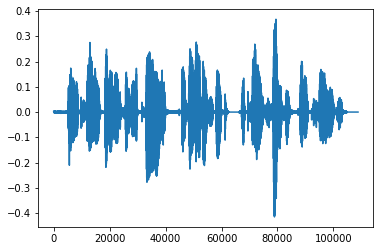

In [ ]:
waveform, sample_rate = torchaudio.load(f'{speaker_84_data_dir}/121123/84-121123-0003.flac')

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

###Get information about audio file include the duration time in seconds

In [ ]:
print(sf.info(f'{speaker_84_data_dir}/121123/84-121123-0003.flac'))

/content/drive/MyDrive/DeepProject/wav2vec/LibriSpeech/dev-clean/84/121123/84-121123-0003.flac
samplerate: 16000 Hz
channels: 1
duration: 6.800 s
format: FLAC (Free Lossless Audio Codec) [FLAC]
subtype: Signed 16 bit PCM [PCM_16]


##On Top Model

In [ ]:
class NAIVE_SV(nn.Module):
    '''This class represents a model that can take as input a [512,width]
      (width -> ?[sec] uuterance) and outputs a softmax for speaker verification
       task.
       Model Architecture:
       1. Avg pool on whole time axis (298 samples)
       2. Linear transformation that will output as number of speakers'''

    def __init__(self, width, speakers_num):
        super(NAIVE_SV, self).__init__()
        self._height = 512  # according wav2vec last conv layer kernels amount
        self._width = width
        self.speakers_num = speakers_num
        self.avg_pool = nn.AvgPool1d(kernel_size=self._width)
        self.fc = nn.Sequential(
            nn.Linear(self._height, self.speakers_num),
            nn.ReLU()
        )
        # Dont think we need any regularization for this thin network but just in case:
        # self.batch_norm = nn.BatchNorm1d(self.speakers_num)
        # self.drop = nn.Dropout(0.5)  #Hard coded probability for now...

    def forward(self, x):
        # Forward pass
        x = self.avg_pool(x)
        x = x.view(-1, self._height)
        x = self.fc(x)
        return x


# maybe for future use:
class SIAMESE_SV(nn.Module):
    def __init__(self, width, speakers_num):
        super(SIAMESE_SV, self).__init__()
        self._height = self._height  # according wav2vec last conv layer kernels amount
        self._width = width
        self.speakers_num = speakers_num
        self.avg_pool = nn.AvgPool1d(kernel_size=self._width)
        self.fc = nn.Sequential(
            nn.Linear(self._height, self.speakers_num),
            nn.ReLU()
        )

        def forward_once(self, x):
            # Forward pass
            x = self.avg_pool(x)
            x = x.view(-1, self._height)
            x = self.fc(x)
            return x

        def forward(self, input1, input2):
            # forward pass of input 1
            output1 = self.forward_once(input1)
            # forward pass of input 2
            output2 = self.forward_once(input2)
            # returning the feature vectors of two inputs
            return output1, output2


##Contrastive Loss Definition (future use)

In [ ]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
  
  
  def forward(self, output1, output2, label):
    # Find the pairwise distance or eucledian distance of two output feature vectors
    euclidean_distance = F.pairwise_distance(output1, output2)  #maybe use another distance like cosine similarity function
    # perform contrastive loss calculation with the distance
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

##Declare Model, Criterion and Optimizer

In [ ]:
%%time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #setting GPU device
print(device)
net = NAIVE_SV(width, num_speakers).to(device) #declare model
criterion = nn.CrossEntropyLoss() #Combines nn.LogSoftmax() & nn.NLLLoss
optimizer = optim.Adam(net.parameters(), lr=learning_rate)  #need to check what the wav2vec2 paper did with the learning rate (i think it was frozen for big amount of steps and afterwards updated each step)
print(net)

#just checking it out:
net.to(device)
net.train()
a, l = next(iter(my_train_loader))
a = a.to(device)
l = l.to(device)
print(f'Got {l.shape} of: {l}')
outputs = net(a)
print(f'outputs shape = {outputs.shape}')
with torch.no_grad():
  loss = criterion(outputs, l)
  speakers_ids, top_class_index = outputs.topk(1, dim=1)
  print(f'************{top_class_index.shape}')
  print(f'The speakers are {l[:6]}')
  print(speakers_ids)
  print(top_class_index)
  print(f'Top class indices are: {top_class_index[:6]}')

cuda:0
NAIVE_SV(
  (avg_pool): AvgPool1d(kernel_size=(298,), stride=(298,), padding=(0,))
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=169, bias=True)
    (1): ReLU()
  )
)


ValueError: ignored

##Classfication Generic Training Code

####For Re-training

In [ ]:
net = torch.load('DataLoader_state.pt')

####Train

In [ ]:
%%time
import time
rootDir = '/content/drive/MyDrive/DeepProject/wav2vec/'


def evaluation(net, dataloader):
  '''This function will calculate the accuracy in gpu'''
  #keeping the network in evaluation mode 
  net.eval()
  total, correct = 0, 0
  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()
  net.train()
  return 100 * correct / total


batches_counter = 0
train_accuracy = torch.zeros(epochs)
test_accuracy = torch.zeros(epochs)
#Loop over epochs
for epoch in range(epochs):
  time0 = time.time() #set timer
  #moving model to GPU & keeping the network in training mode
  net.to(device)
  net.train()
  #iterate through all the batches in each epoch
  time1 = time.time()
  for i, data in enumerate(my_train_loader, 0):
    #get inputs and labels and move them to gpu
    inputs, labels = data[0].to(device), data[1] .to(device)
    #clear the gradients
    optimizer.zero_grad()
    #make a forward pass
    outputs = net(inputs)
    #calculate loss
    loss = criterion(outputs, labels)
    #backward pass
    loss.backward()
    #perform a single optimization step (parameter update)
    optimizer.step()
    if i % 50 == 0:
      if batches_counter % 4 == 0:
        #will save networks params after 200 batches update!
        checkpoint = {
            'state_dict': net.state_dict(),
            'epochs': epoch,
            'batches_in_epoch': i
        }
        torch.save(checkpoint, f'{rootDir}/DataLoader_state.pt')
      print(f'Trained for {batches_counter * 50} batches in {(time.time() - time1):.2f}[sec]')
      batches_counter = batches_counter + 1
      time1 = time.time()
  print(f'Finished training all batches in {(time.time() - time0):.2f}[sec]')

  #Validation:
  for i, data in enumerate(my_train_loader, 0):
       with torch.no_grad():
         net.eval()
         inputs, labels = data[0].to(device), data[1].to(device)
         print(f'Real speakers are = {labels}')
         outputs = net(inputs) 
         #get the most likely label predicted
         _, top_class = outputs.topk(1, dim=1)
         print(f'Network thinks speaker is = {top_class} while true speaker is = {}')
         #get number of matches with the real labels
         equals = top_class == labels.view(*top_class.shape)
         print(equals)
         train_accuracy[epoch] += torch.sum(equals.type(torch.FloatTensor))
         print(train_accuracy[epoch])
  
  # test_acc = evaluation(net, my_test_loader)
  
  # test_accuracy[epoch] = test_acc
  train_accuracy[epoch] = train_accuracy[epoch]/len(my_train_data)
  # print(f'Epoch {epoch + 1}/{epochs} Accuracy: Train = {(train_accuracy[epoch] * 100):.3f}% , Test = {test_acc:.3f}%')
  print(f'Epoch {epoch + 1}/{epochs} Accuracy: Train = {(train_accuracy[epoch] * 100):.3f}%')
  print(f'Finished pass through epoch in {time.time() - time0}[sec]')


#save here the results with torch.save in the specific path of this regularization method
print('Saving state_dict...')
checkpoint = {
    'state_dict': net.state_dict(),
    'train_acc': train_accuracy,
    'test_acc': test_accuracy
}
saved_model_path = f'{rootDir}/results/SV_checkpoint.pt'
torch.save(checkpoint, saved_model_path)

Streaming output truncated to the last 5000 lines.
        [ 13],
        [102],
        [ 13],
        [ 98],
        [169],
        [179],
        [169],
        [144],
        [ 47],
        [144],
        [164],
        [164],
        [ 98],
        [179],
        [ 47],
        [ 98],
        [ 13]], device='cuda:0')
tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False]], device='cuda:0')
tensor(2571.)
yo
tensor([[ 47],
        [ 13],
        [ 77],
        [ 58],
        [169],
        [169],
       

##Siamese Generic Training Code

In [ ]:
%%time
net = SIAMESE_SV.to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)